# Dependencies

In [1]:
pacman::p_load(dplyr, ggplot2, pBrackets, ggpubr, cowplot)

# Functions

In [2]:
source("/Users/anabbi/git/ped_CapTCRseq/R/ggplot2_theme.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/color_schemes.R")

# Paths

In [3]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"
gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"

In [4]:
h4hpath <- "/Users/anabbi/Desktop/H4H/INTERCEPT/"

# Main

bind all metadata

In [5]:
meta_div <- readr::read_rds(file = paste0(datapath,"capTCRseq/meta_div_goodsamples.rds"))

In [6]:
subset_meta <- meta_div[, c("Patient", "cycle", "FOLD", "Disease_type", 
"CD3", "cancergroup", "sampletype", "TRB", "Age")]

In [7]:
# recode cycle to numeric
subset_meta$cycle <- gsub("X", "", subset_meta$cycle)

In [8]:
subset_meta$cycle <- as.numeric(subset_meta$cycle)

In [9]:
table(subset_meta$sampletype, useNA = "ifany")


 PBMC Tumor cfDNA 
  481    18   274 

In [10]:
# NAs are flow
subset_meta$sampletype[ is.na(subset_meta$sampletype) ] <- "Flow"

In [11]:
#remove Tumor samples
subset_meta <- subset_meta[ which(subset_meta$sampletype != "Tumor"),]
#remove Normal samples
subset_meta <- subset_meta[ which(subset_meta$cancergroup != "Normal"),]
# remove LFS samples
subset_meta <- subset_meta[which(subset_meta$cancergroup != "LFS"),]

In [12]:
table(subset_meta$sampletype, useNA = "ifany")


 PBMC cfDNA 
  457   274 

In [13]:
length(table(subset_meta$Patient))

[1] 119

In [14]:
mydat <- matrix(ncol = 20, nrow = length(unique(subset_meta$Patient)))
rownames(mydat) <- unique(subset_meta$Patient)
# assign colnames 5 PBMCs, 5 cfDNA, 5 FOLD,  5 CD3 separate by _
colnames(mydat) <- c(paste0(rep("PBMC_", 5), 1:5),
                        paste0(rep("cfDNA_", 5), 1:5),
                        paste0(rep("FOLD_", 5), 1:5),
                        paste0(rep("CD3_", 5), 1:5))

In [15]:
datatype.fx <- function(x){

x$datatype <- NA
for(i in 1:nrow(x)){
#if is.na(TRB) & !is.na(FOLD) & !is.na(CD3), then datatype = FOLD,CD3
    if(is.na(x$TRB[i]) & !is.na(x$FOLD[i]) & !is.na(x$CD3[i])){
        x$datatype[i] <- paste0("FOLD", "_",x$cycle[i], ",", "CD3","_", x$cycle[i])
    }
#if is.na(TRB) & !is.na(CD3) & is.na(FOLD), then datatype = CD3
    if(is.na(x$TRB[i]) & !is.na(x$CD3[i]) & is.na(x$FOLD[i])){
        x$datatype[i] <- paste0("CD3","_", x$cycle[i])
    }
#if is.na(TRB) & is.na(CD3) & !is.na(FOLD), then datatype = FOLD
    if(is.na(x$TRB[i]) & !is.na(x$FOLD[i]) & is.na(x$CD3[i])){
        x$datatype[i] <- paste0("FOLD","_", x$cycle[i])
    }
#if !is.na(TRB) & !is.na(CD3) & is.na(FOLD) & sampletype == "PBMC", then datatype = PBMC, CD3
    if(!is.na(x$TRB[i]) & !is.na(x$CD3[i]) & is.na(x$FOLD[i]) & x$sampletype[i] == "PBMC"){
        x$datatype[i] <- paste0("PBMC","_", x$cycle[i], ",", "CD3","_", x$cycle[i])
    }

#if !is.na(TRB) & is.na(CD3) & !is.na(FOLD) & sampletype == "PBMC", then datatype = PBMC, FOLD
    if(!is.na(x$TRB[i]) & is.na(x$CD3[i]) & !is.na(x$FOLD[i]) & x$sampletype[i] == "PBMC"){
        x$datatype[i] <- paste0("PBMC","_", x$cycle[i], ",", "FOLD","_", x$cycle[i])
    }

#if !is.na(TRB) & & !is.na(CD3) & !is.na(FOLD) & sampletype == "PBMC", then datatype = PBMC, FOLD, CD3
    if(!is.na(x$TRB[i]) & !is.na(x$CD3[i]) & !is.na(x$FOLD[i]) & x$sampletype[i] == "PBMC"){
        x$datatype[i] <- paste0("PBMC","_", x$cycle[i], ",", "FOLD","_", x$cycle[i], ",", "CD3","_", x$cycle[i])
    }
#if sampletype == "cfDNA", then datatype = cfDNA
    if(x$sampletype[i] == "cfDNA"){
        x$datatype[i] <- paste0("cfDNA","_", x$cycle[i])
    }
}

# separate_rows based on , in datatype_cycle
x_s <- x %>% tidyr::separate_rows(datatype, sep = ",")

pw <- tidyr::pivot_wider(x_s[, c("Patient", "datatype", "Age")], 
names_from = datatype, values_from = Age)

pw <- as.data.frame(pw)
rownames(pw) <- pw$Patient
pw$Patient <- NULL

# match colnames(pw) with colnames(mydat), pw$Patient with rownames(mydat)
mydat[ rownames(pw), colnames(pw)] <- as.matrix(pw) 
#print(pw)
return(mydat)
}

In [16]:
table(subset_meta$cancergroup, useNA = "ifany")


    Leukemia     Lymphoma Solid tumors 
         361          136          234 

In [17]:
dim(meta_div)

[1] 773  64

In [18]:
for(p in unique(subset_meta$Patient)){
    x <- subset_meta[subset_meta$Patient == p, ]
    mydat <- datatype.fx(x)
}

In [19]:
mydat_m <- reshape2::melt(mydat, na.rm = TRUE)

In [20]:
mydat_m$cycle <- gsub(".*_", "", mydat_m$Var2)
mydat_m$Datatype <- gsub("_.*", "", mydat_m$Var2)

In [21]:
mydat_m$cycle <- as.factor(mydat_m$cycle)

In [22]:
mydat_m$cancergroup <- subset_meta$cancergroup[match(mydat_m$Var1, subset_meta$Patient)]

In [23]:
table(mydat_m$Datatype, useNA = "ifany")


  CD3  FOLD  PBMC cfDNA 
  456   452   197   274 

In [24]:
patients_cycles <- cbind.data.frame( unique(mydat_m$Var1), "5")
colnames(patients_cycles) <- c("Patient", "cycle")
patients_cycles$Patient <- as.character(patients_cycles$Patient)

patients_cycles$cancergroup <- subset_meta$cancergroup[match(patients_cycles$Patient, subset_meta$Patient)]
patients_cycles$Disease_type <- subset_meta$Disease_type[match(patients_cycles$Patient, subset_meta$Patient)]
patients_cycles$Age <- subset_meta$Age[match(patients_cycles$Patient, subset_meta$Patient)]

In [25]:
patients_cycles$Patient <- factor(patients_cycles$Patient, levels = patients_cycles$Patient[order(patients_cycles$cancergroup, 
patients_cycles$Disease_type, patients_cycles$Age)])

In [26]:
mydat_m$Var1 <- factor(mydat_m$Var1, levels = levels(patients_cycles$Patient))

In [27]:
patients_cycles$cycle <- as.numeric(patients_cycles$cycle)

In [28]:
mydat_m$cycle <- as.numeric(mydat_m$cycle)

In [29]:
# recode cycle to 6, just for plotting
patients_cycles$cycle <- ifelse(patients_cycles$cycle == 5, 6, patients_cycles$cycle)

In [30]:
mydat_m$Var2 <- as.character(mydat_m$Var2)

In [31]:
mydat_m$Datatype[mydat_m$Datatype == "PBMC"] <- "CapTCR-seq(PBMC)"
mydat_m$Datatype[mydat_m$Datatype == "cfDNA"] <- "CapTCR-seq(cfDNA)"
mydat_m$Datatype[mydat_m$Datatype == "FOLD"] <- "ex vivo T-cell expansion"
mydat_m$Datatype[mydat_m$Datatype == "CD3"] <- "Flow cytometry"

In [32]:
mydat_m$newcycle <- NA

for(i in 1:5){
    mydat_m$newcycle[mydat_m$cycle == i & mydat_m$Datatype == "CapTCR-seq(PBMC)"] <- i-0.2
    mydat_m$newcycle[mydat_m$cycle == i & mydat_m$Datatype == "CapTCR-seq(cfDNA)"] <- i-0.1
    mydat_m$newcycle[mydat_m$cycle == i & mydat_m$Datatype == "ex vivo T-cell expansion"] <- i + 0.1
    mydat_m$newcycle[mydat_m$cycle == i & mydat_m$Datatype == "Flow cytometry"] <- i+ 0.2
}

In [33]:
dim(patients_cycles)

[1] 119   5

In [34]:
p0 <- ggplot(patients_cycles, aes(Patient, cycle)) +
  geom_bar(stat = "identity", aes(fill = cancergroup), width = 0.8, alpha = 0.2) +
  geom_point(data = mydat_m, aes(Var1, newcycle, colour = Datatype, shape = Datatype), size = 1.5) +
  coord_flip() +
  scale_fill_manual(values = group_col[c("Leukemia", "Lymphoma", "Solid tumors")]) +
  scale_color_brewer(palette = "Set1") +
  scale_shape_manual(values = c(15, 16, 17, 18)) +
  scale_y_continuous(expand = c(0, 0), limits = c(0, 6), breaks = c(1, 2, 3, 4, 5), labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")) +
  myplot +
  theme(
    axis.title.y = element_blank(), 
    axis.text.y = element_text(size = 10), 
    axis.ticks.x = element_blank(), 
    plot.margin = unit(c(0.1, 0.2, 0.1, 0.2), "cm"),
    axis.line.x = element_line(colour = "black"), 
    axis.text.x = element_text(size = 20, angle = 45, hjust = 1), 
    axis.title.x = element_blank()
  )


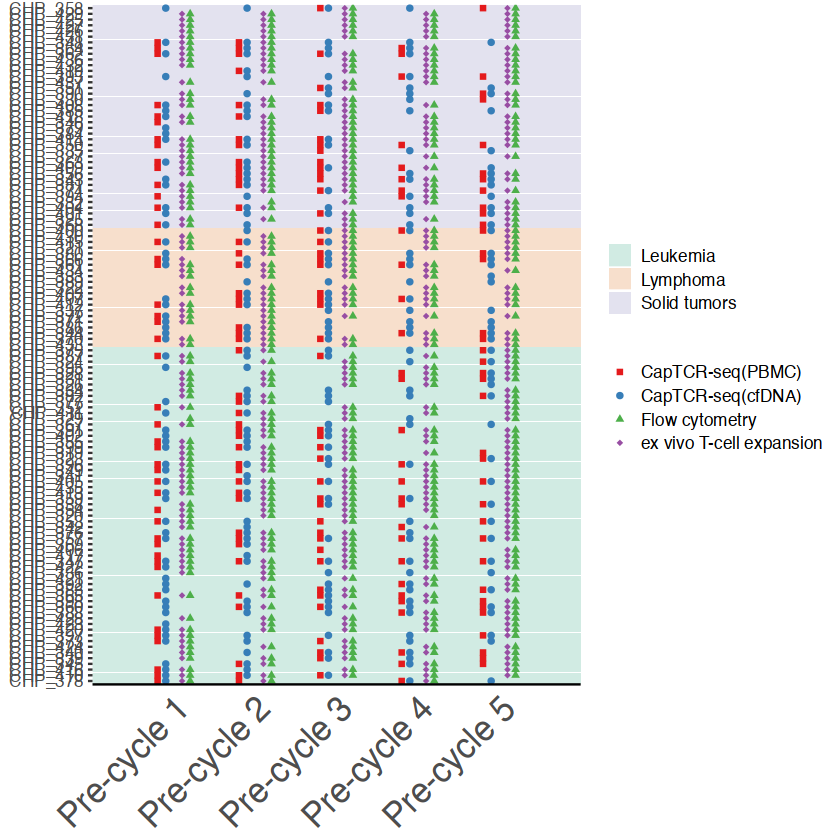

In [35]:
p0

age barplot on the right

In [36]:
group_col

Leukemia     Lymphoma Solid tumors          LFS       Normal 
   "#1B9E77"    "#D95F02"    "#7570B3"      "black" "light grey"

In [37]:
p1 <- ggplot(patients_cycles, aes(Patient, Age)) +
  geom_bar(stat = "identity", aes(fill = cancergroup), width = 0.8, alpha = 0.2) +
  coord_flip() +
  scale_fill_manual(values = group_col[c("Leukemia", "Lymphoma", "Solid tumors")]) +
  myplot +
  theme(
    legend.position = "none", plot.margin = unit(c(0.1, 0.1, 0.1, 0.2), "cm"),
    axis.text.y = element_blank(), axis.title.y = element_blank(), axis.title.x = element_text(size = 20),
    axis.line.x = element_line(colour = "black"), axis.text.x = element_text(size = 20)
  )

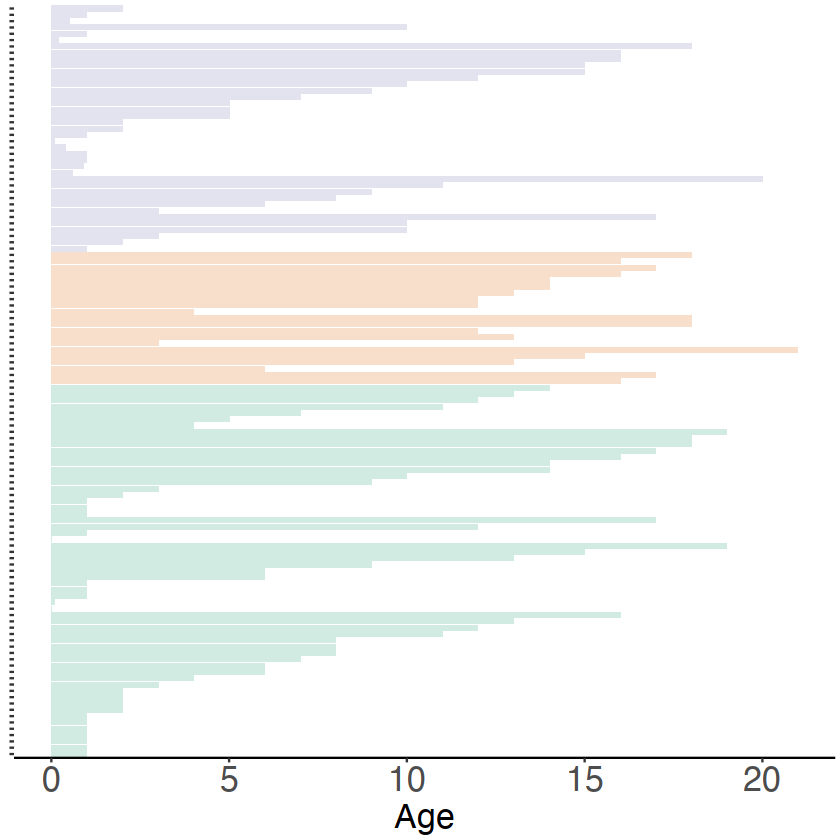

In [38]:
p1

In [39]:
# Add disease type as labels
p0 <- p0 + theme(legend.position = "none") +
scale_x_discrete(labels = patients_cycles$Disease_type[match(levels(patients_cycles$Patient), patients_cycles$Patient)]) 

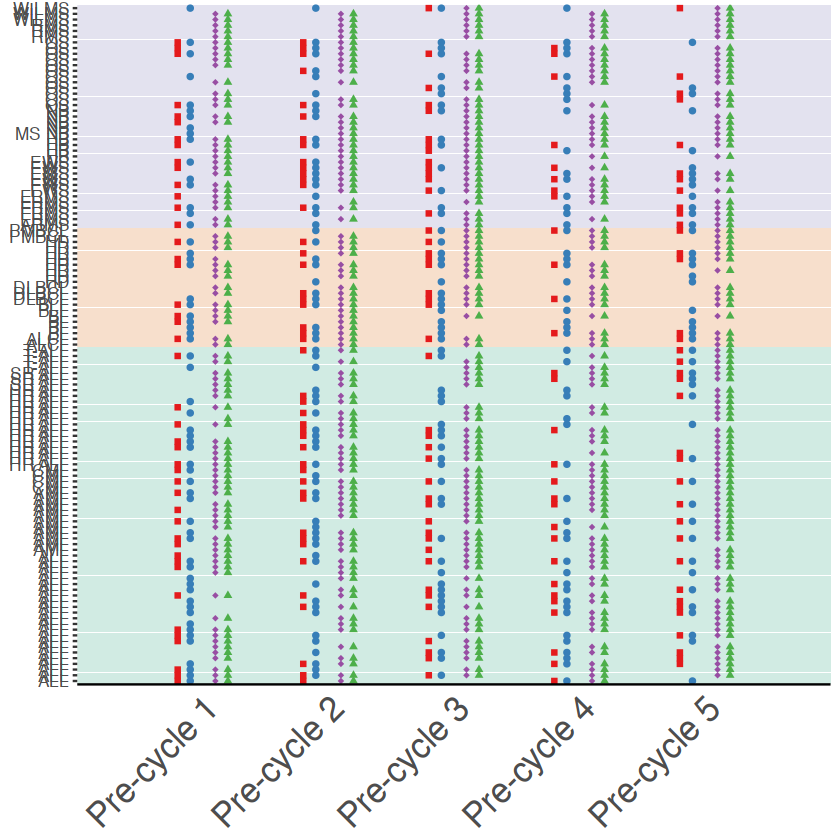

In [40]:
p0

In [41]:
table(patients_cycles$cancergroup)


    Leukemia     Lymphoma Solid tumors 
          59           21           39 

In [42]:
p1b <- p1 + geom_bracket(xmin = c(1, 60, 81), xmax = c(59, 80, 120), y.position = c(22, 22,22),
  label.size = 7, label = c("", "", ""), coord.flip = T) + # changes the orientaitons of labels, set without label, then add with annotate
  scale_y_continuous(expand = c(0,0), limits = c(0,35), breaks = c(5,10,15,20)) +
  annotate("text", x = c(29.5, 69.5, 99.5), y = c(22.5, 22.5,22.3), label = c("Leukemia", "Lymphoma", "Solid tumors"), size = 7, hjust = 0) + labs(y = "Age (Years)")

In [43]:
# allp <- plot_grid(p0 , p1,
# ncol = 2, rel_widths = c(1, 0.3))

In [44]:
# pdf(paste0(plotpath,"swimmerplot.pdf"), width=10, height=16)
# allp #+  theme(aspect.ratio = 4/2)
# dev.off()

In [45]:
pdf(paste0(plotpath,"swimmerplot_lgd.pdf"), width=5, height=5)

grid::grid.draw( get_legend(p0 + 
theme(legend.position = 'right', legend.box = 'vertical', legend.margin = margin(0,0,0,0)) +
guides(colour = guide_legend(override.aes = list(size=3)))) )

dev.off()

pdf 
  2

## Add clinical heatmap

In [46]:
table(subset_meta$cancergroup)


    Leukemia     Lymphoma Solid tumors 
         361          136          234 

In [47]:
clinical <- meta_div[, c("Patient", "Remission", "Relapse", "Transplant", "CART")]

In [48]:
clinical$Patient <- factor(clinical$Patient, levels = levels(patients_cycles$Patient) )# match order of patients

In [49]:
clinical_melt <- reshape2::melt(clinical[, c("Patient", "Remission", "Relapse", "Transplant", "CART")], id.vars = "Patient")

In [50]:
clinical_melt[ is.na(clinical_melt$value), "value" ] <- 0

In [51]:
clinical_melt$value <- as.numeric(clinical_melt$value)

In [52]:
gg_hm <- ggplot(data = clinical_melt, aes(x = variable, y = Patient, fill = value)) + 
  geom_tile() + myplot + myaxis + 
  theme(legend.position = "none", axis.title = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
  plot.margin = unit(c(0.1, 0.2, 1, 1), "cm"),
  panel.border = element_rect(color = "black", fill = NA, size = 0.5)) + 
  scale_fill_gradient(low = "white", high = "black")

Warning message:
"The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."


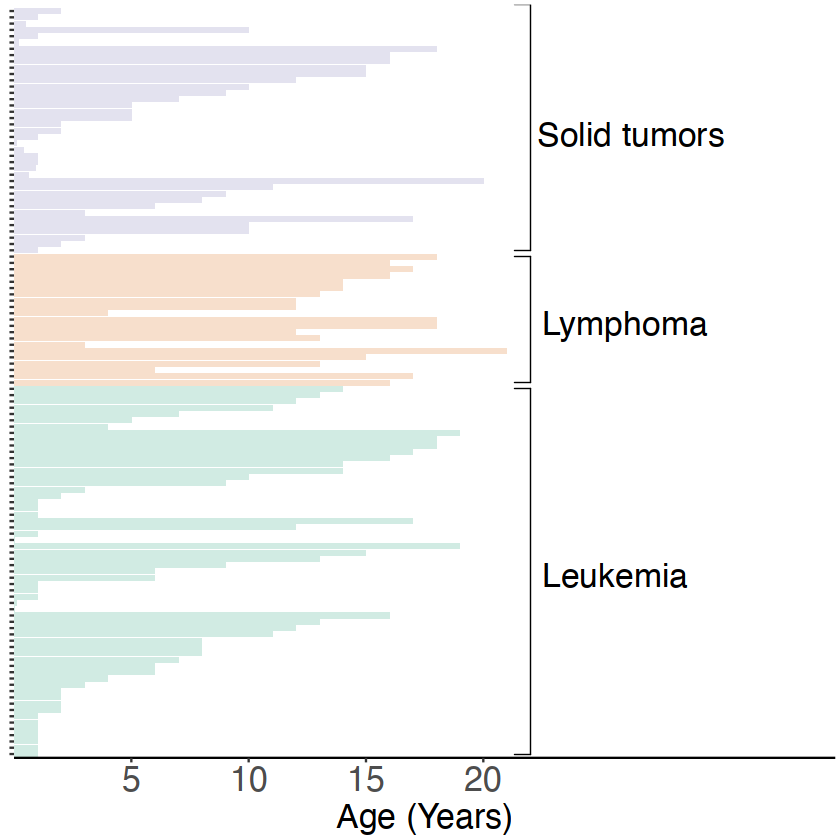

In [53]:
p1b

In [54]:
pdf(paste0(plotpath,"swimmerplot_clinical.pdf"), width=12, height=14)
plot_grid(p0, gg_hm,p1b, ncol = 3, align = "h", rel_widths = c(3,0.8, 1.5)) 
dev.off()


pdf 
  2

Descriptives for main text

In [55]:
# remove ffpe samples
tmp <- meta_div[ !meta_div$sampletype %in% "Tumor",]
# remove normals and lfs
tmp <- tmp[ which(tmp$cancergroup != "Normal"),]
tmp <- tmp[ which(tmp$cancergroup != "LFS"),]

In [56]:
length(table(tmp$Patient))
table(tmp$sampletype, useNA = "always")

[1] 119


 PBMC cfDNA  <NA> 
  457   274     0 

In [57]:
myfreq <- as.data.frame(table(tmp$cancergroup, tmp$Patient) , stringsAsFactors = F) 
myfreq <- myfreq[ which(myfreq$Freq != 0),]

In [58]:
head(myfreq)

,Var1,Var2,Freq
,<chr>,<chr>,<int>
1,Leukemia,CHP_319,5
4,Leukemia,CHP_320,5
8,Lymphoma,CHP_321,5
11,Lymphoma,CHP_322,5
13,Leukemia,CHP_323,6
16,Leukemia,CHP_324,6


In [59]:
dim(myfreq)

[1] 119   3

In [60]:
table(myfreq$Var1)


    Leukemia     Lymphoma Solid tumors 
          59           21           39 

In [61]:
myfreq <- as.data.frame(table(tmp$Disease_type, tmp$Patient) , stringsAsFactors = F) 
myfreq <- myfreq[ which(myfreq$Freq != 0),]

In [62]:
table(myfreq$Var1)


  ALCL    ALL    AML   ARMS     BL    BLL    CML  DLBCL   ERMS    EWS     HB 
     2     23     11      1      4      2      4      3      5      6      4 
    HD HR ALL  MS NB     NB     OS  PMBCL    RMS SR ALL  T-ALL  WILMS 
     8     14      1      4     12      2      3      3      4      3 

In [63]:
rm(tmp)

In [64]:
# remove ffpe samples
# column sampletype includes NA (they are flow data without TCR), if using which ==, it will remove all NA
tmp <- meta_div[ !meta_div$sampletype %in% "Tumor",]
# remove normals and lfs
tmp <- tmp[ which(tmp$cancergroup != "Normal"),]
tmp <- tmp[ which(tmp$cancergroup != "LFS"),]

#tmp <- tmp[ which(tmp$sampletype == "PBMC"),]

myfreq <- as.data.frame(table(tmp$cancergroup[!is.na(tmp$CD3)], tmp$Patient[!is.na(tmp$CD3)]) , stringsAsFactors = F) 
myfreq <- myfreq[ which(myfreq$Freq != 0),]

In [65]:
dim(myfreq)

[1] 119   3

In [66]:
table(myfreq$Var1)


    Leukemia     Lymphoma Solid tumors 
          59           21           39 

In [67]:
tmp <- meta_div[ which(meta_div$sampletype == "PBMC"),]

In [68]:
length(unique(tmp$Patient[ !is.na(tmp$CD3) ]))

[1] 118

In [69]:
length(tmp$Patient[ !is.na(tmp$CD3) ])

[1] 456

In [70]:
dim(tmp[ !is.na(tmp$FOLD), ])

[1] 452  64

In [71]:
tmp <- meta_div[ which(meta_div$sampletype == "Tumor"),]

In [72]:
table(tmp$Disease_type)


 ALCL    BL   BLL DLBCL  ERMS    HD    NB    OS PMBCL 
    1     2     1     1     4     4     1     3     1 

In [73]:
table(meta_div$sampletype[!is.na(meta_div$TRB)])


 PBMC Tumor cfDNA 
  221    17   266 

In [74]:
colnames(meta_div)

[1] "sample_id"          "Patient"            "cycle"             
 [4] "FOLD"               "ATC"                "Age"               
 [7] "Disease_type"       "TE_fold"            "CD3"               
[10] "EM"                 "CM"                 "Na\303\257ve"      
[13] "SCM"                "TE"                 "EM%"               
[16] "CM%"                "Na\303\257ve%"      "SCM%"              
[19] "TE%"                "Na\303\257ve/TE"    "N+CM+SCM/TE+EM"    
[22] "PD-1"               "PDL1"               "LAG3"              
[25] "TIM3"               "CTLA4"              "PD1%"              
[28] "PDL1%"              "LAG3%"              "TIM3%"             
[31] "CTLA4%"             "Any NCR"            "PD1 + LAG3 + TIM3" 
[34] "cancergroup"        "agegroup"           "foldgroup"         
[37] "Remission"          "Relapse"            "Transplant"        
[40] "CART"               "TRB"                "Reads"             
[43] "CPKR"               "Average_reads"      "VMR"               
[46] "Max_reads"          "Singletons"         "Doubletons"        
[49] "qD"                 "Sample_Coverage"    "observed_Richness" 
[52] "estimated_Richness" "SE_Richeness"       "observed_Shannon"  
[55] "estimated_Shannon"  "SE_Shannon"         "observed_Simpson"  
[58] "estimated_Simpson"  "SE_Simpson"         "basename"          
[61] "file"               "Group"              "sampletype"        
[64] "log10shann"

In [75]:
head(tmp)

,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,estimated_Shannon,SE_Shannon,observed_Simpson,estimated_Simpson,SE_Simpson,basename,file,Group,sampletype,log10shann
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
163,CHP_344_A,CHP_344,X00,NA,NA,NA,BL,NA,NA,NA,...,4.811,0.055,4.009,4.013,0.069,CHP_344_A-FFPE-DNA,batchFFPE_3Apr2020/mixcr/clones/CLONES_TRBCHP_344_A-FFPE-DNA.txt,CHP,Tumor,0.6818741
285,CHP_361,CHP_361,X00,NA,NA,NA,HD,NA,NA,NA,...,104.826,0.437,83.093,83.360,0.772,CHP_361-FFPE-DNA_S1,batchFFPE_3Apr2020/mixcr/clones/CLONES_TRBCHP_361-FFPE-DNA_S1.txt,CHP,Tumor,2.0192202
312,CHP_364,CHP_364,X00,NA,NA,NA,OS,NA,NA,NA,...,7.136,0.123,5.434,5.443,0.144,CHP_364-FFPE-DNA_S1,batchFFPE_3Apr2020/mixcr/clones/CLONES_TRBCHP_364-FFPE-DNA_S1.txt,CHP,Tumor,0.8527239
328,CHP_366,CHP_366,X00,NA,NA,NA,HD,NA,NA,NA,...,4.726,0.076,3.425,3.428,0.073,CHP_366-FFPE-DNA_S1,batchFFPE_3Apr2020/mixcr/clones/CLONES_TRBCHP_366-FFPE-DNA_S1.txt,CHP,Tumor,0.6739420
358,CHP_370,CHP_370,X00,NA,NA,NA,ALCL,NA,NA,NA,...,2.555,0.013,2.267,2.267,0.009,CHP_370-FFPE-DNA_S5,batchFFPE_3Apr2020/mixcr/clones/CLONES_TRBCHP_370-FFPE-DNA_S5.txt,CHP,Tumor,0.4073909
376,CHP_372,CHP_372,X00,NA,NA,NA,BL,NA,NA,NA,...,2.412,0.051,1.739,1.740,0.032,CHP_372-FFPE-DNA_S1,batchFFPE_3Apr2020/mixcr/clones/CLONES_TRBCHP_372-FFPE-DNA_S1.txt,CHP,Tumor,0.3812956


In [76]:
tmp <- meta_div[ which(meta_div$sampletype == "PBMC"),]
tmp <- tmp[ !duplicated(tmp$Patient),]
table(tmp$Relapse[ tmp$Disease_type %in% c("ALL", "HR ALL", "SR ALL", "T-ALL" )], useNA = "always")


   1 <NA> 
   4   40 

In [77]:
table(tmp$Disease_type)


  ALCL    ALL    AML   ARMS     BL    BLL    CML  DLBCL   ERMS    EWS     HB 
     2     23     11      1      4      2      4      3      5      6      4 
    HD HR ALL    LFS  MS NB     NB Normal     OS  PMBCL    RMS SR ALL  T-ALL 
     7     14     10      1      4     14     12      2      3      3      4 
 WILMS 
     3 

In [78]:
tmp[ tmp$Patient == "CHP_411", "Relapse"]

[1] NA

In [79]:
tmp$cancergroup

[1] "Normal"       "Normal"       "Normal"       "Normal"       "Normal"      
  [6] "Normal"       "Normal"       "Normal"       "Normal"       "Leukemia"    
 [11] "Leukemia"     "Leukemia"     "Leukemia"     "Solid tumors" "Leukemia"    
 [16] "Solid tumors" "Leukemia"     "Leukemia"     "Leukemia"     "Leukemia"    
 [21] "Solid tumors" "Lymphoma"     "Leukemia"     "Solid tumors" "Leukemia"    
 [26] "Solid tumors" "Leukemia"     "Solid tumors" "Solid tumors" "Leukemia"    
 [31] "Leukemia"     "Leukemia"     "Leukemia"     "Solid tumors" "Leukemia"    
 [36] "Solid tumors" "Leukemia"     "Leukemia"     "Lymphoma"     "Solid tumors"
 [41] "Solid tumors" "Solid tumors" "Leukemia"     "Lymphoma"     "Leukemia"    
 [46] "Solid tumors" "Leukemia"     "Lymphoma"     "Lymphoma"     "Lymphoma"    
 [51] "Leukemia"     "Solid tumors" "Leukemia"     "Leukemia"     "Leukemia"    
 [56] "Leukemia"     "Lymphoma"     "Solid tumors" "Leukemia"     "Leukemia"    
 [61] "Solid tumors" "Lymphoma"     "Leukemia"     "Leukemia"     "Solid tumors"
 [66] "Leukemia"     "Leukemia"     "Solid tumors" "Solid tumors" "Leukemia"    
 [71] "Leukemia"     "Leukemia"     "Leukemia"     "Normal"       "Normal"      
 [76] "Normal"       "Lymphoma"     "Solid tumors" "Leukemia"     "Lymphoma"    
 [81] "Solid tumors" "Leukemia"     "Leukemia"     "Lymphoma"     "Solid tumors"
 [86] "Solid tumors" "Leukemia"     "Leukemia"     "Lymphoma"     "Leukemia"    
 [91] "Solid tumors" "Lymphoma"     "Leukemia"     "Leukemia"     "Solid tumors"
 [96] "Solid tumors" "Leukemia"     "Leukemia"     "Normal"       "Normal"      
[101] "Leukemia"     "Lymphoma"     "Lymphoma"     "Solid tumors" "Leukemia"    
[106] "Solid tumors" "Leukemia"     "Solid tumors" "Lymphoma"     "Leukemia"    
[111] "Leukemia"     "Lymphoma"     "Leukemia"     "Solid tumors" "Solid tumors"
[116] "Leukemia"     "Leukemia"     "Leukemia"     "Leukemia"     "Solid tumors"
[121] "Solid tumors" "Solid tumors" "Leukemia"     "Solid tumors" "Lymphoma"    
[126] "Solid tumors" "Solid tumors" "Lymphoma"     "Lymphoma"     "Leukemia"    
[131] "Solid tumors" "Solid tumors" "LFS"          "LFS"          "LFS"         
[136] "LFS"          "LFS"          "LFS"          "LFS"          "LFS"         
[141] "LFS"          "LFS"